In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model

### Taking reference from https://medium.com/@vijendra1125/ocr-part-2-ocr-using-cnn-f43f0cee8016 and https://github.com/SIDD58/Captcha-recognition-using-CNN

### The idea behind the model is to construct a cnn model which extracts all the important features and after flattening connects to 5 separate sets of nn each corresponding to a letter in the captcha

In [2]:
# importing the images in the shape required by tensorflow

X = np.zeros((1070,50,200,1))
for i in range(1,1071): 
    image=np.reshape(np.array(tf.keras.utils.load_img(f'{i}.png',color_mode='grayscale',target_size=(50,200))),(50,200,1))/255
    
    X[i-1,:,:,:]=image
    

In [3]:
# importing the dataset and correcting it

target=pd.read_csv('C:\\Users\\manas\\OneDrive\\Desktop\\bsc secy task\\CaptchaDataset\\dataset1\\mapping.csv')
target['captcha'][17]="3bfnd"

#### We will one hot encode into a 5*1070*36 matrix in which 5 corresponds to the number of letters,1070 is number of data points and 36 is the number of possible charaters with 0-9 being 0-9 and a-z being 10-35

In [4]:
# one hot encoding the captcha for each of the 5 letters

def hot_encode(labels):
    encoded = np.zeros((5, 1070, 36), dtype=np.float32)
    for i, label in enumerate(labels):
        for j, char in enumerate(label):
            if ord(char)<80:
                encoded[j,i ,ord(char) - 48] = 1
            else:
                encoded[j,i ,ord(char)-87] = 1
    return encoded

y = hot_encode(target['captcha'])

In [5]:
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [42]:
input = layers.Input(shape=(50,200,1))
conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input) #50*200
m_pool1 = layers.MaxPooling2D( padding='same')(conv1)  
conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(m_pool1)
m_pool2 = layers.MaxPooling2D( padding='same')(conv2)  
conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(m_pool2)
bn = layers.BatchNormalization()(conv3)
m_pool3 = layers.MaxPooling2D( padding='same')(bn)  
    
flatten = layers.Flatten()(m_pool3) 

# connections the 5 different nn mentioned above
output = []
for _ in range(5): 
    dense1 = layers.Dense(64, activation='relu')(flatten)
    dropout = layers.Dropout(0.5)(dense1)
    output_each = layers.Dense(36, activation='sigmoid')(dropout)

    output.append(output_each)
    


In [43]:
model=Model(input, output);
model.compile( optimizer='adam',loss='categorical_crossentropy')
model.summary();

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 50, 200, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 50, 200, 16)       │             160 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 25, 100, 16)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 25, 100, 32)       │           4,640 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 13, 50, 32)        │               0 │ conv2d_4[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 13, 50, 32)        │           9,248 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 13, 50, 32)        │             128 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 7, 25, 32)         │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 5600)              │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 64)                │         358,464 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 64)                │         358,464 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 64)                │         358,464 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 64)                │         358,464 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 64)                │         358,464 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 64)                │               0 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [44]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=70, validation_split=0.2)

Epoch 1/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - loss: 19.2744 - val_loss: 17.6445
Epoch 2/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 17.1349 - val_loss: 17.4711
Epoch 3/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - loss: 15.9994 - val_loss: 17.2223
Epoch 4/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 15.1614 - val_loss: 16.8904
Epoch 5/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - loss: 14.1110 - val_loss: 16.6615
Epoch 6/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 13.1745 - val_loss: 16.1068
Epoch 7/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 12.1902 - val_loss: 15.7714
Epoch 8/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 11.4718 - val_loss: 15.1870
Epoch 9/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 10.7120 - val_loss: 14.2685
Epoch 10/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - loss: 9.7237 - val_loss: 13.3844
Epoch 11/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 9.1120 - val_loss: 12.2058
Epoch 12/70
25/25 ━━━━━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 1.3151 - val_loss: 2.2541
Epoch 69/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 1.2990 - val_loss: 2.4471
Epoch 70/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 1.2371 - val_loss: 2.2653


In [45]:
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6278


1.2804193496704102

In [46]:
preds=np.array(model.predict(X_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [47]:
# converting the one hot encode back to letters and numbers

pred=[]
for i in range(100):
    temp=[]
    hey=np.argmax(preds[:,i,:],axis=1)
    for j in range(5):
        if hey[j]<=9:
            temp.append(str(hey[j]))
        else:
            temp.append(chr(hey[j]+87))
    pred.append(temp)
#     pred[i,:]=hey

In [48]:
print(pred[0])

['5', '7', '3', '8', 'f']


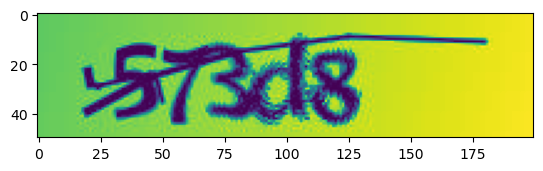

In [41]:
plt.imshow(X_test[0])

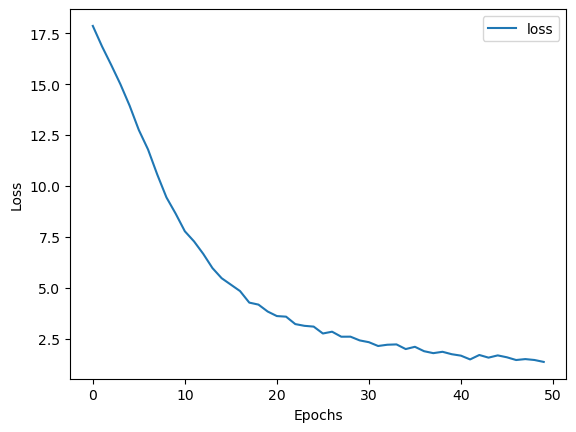

In [14]:
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

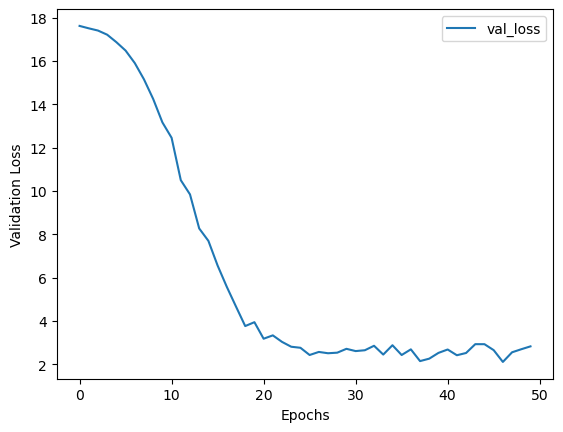

In [15]:
for label in ["val_loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()

In [34]:
def print_captcha(file):
    image=np.reshape(np.array(tf.keras.utils.load_img(file,color_mode='grayscale',target_size=(50,200))),(50,200,1))/255
    X = np.zeros((1,50,200,1))
    X[0,:,:,:]=image
    preds=np.array(model.predict(X))
    
    

    temp=""
    hey=np.argmax(preds[:,0,:],axis=1)
    for j in range(5):
        if hey[j]<=9:
            temp+=(str(hey[j]))
        else:
            temp+=(chr(hey[j]+87))
    plt.imshow(image)
    plt.title(temp)
    plt.axis("off")
    

### Please enter the input file name and directory below

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


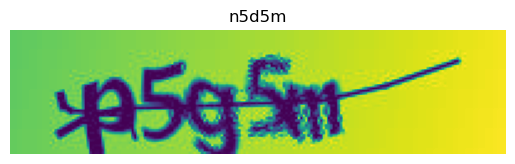

In [35]:
# please enter the test image location
file_location="1.png"


print_captcha(file_location)